In [29]:
import numpy as np
from itertools import product
import pandas as pd
from pykalman import KalmanFilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
# data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Filter out patients with fewer than 3 records
patient_record_counts = data_cleaned['usubjid'].value_counts()
patients_to_keep = patient_record_counts[patient_record_counts >= 3].index
data_cleaned = data_cleaned[data_cleaned['usubjid'].isin(patients_to_keep)]

# Preprocess the data 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Split the data into train and test sets by patients
patients = data_cleaned['usubjid'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

train_data = data_cleaned[data_cleaned['usubjid'].isin(train_patients)]
test_data = data_cleaned[data_cleaned['usubjid'].isin(test_patients)]

# Define the grid of parameters
initial_state_means = [np.zeros(len(features)), np.ones(len(features))]
transition_matrices = [np.eye(len(features)), 0.95 * np.eye(len(features))]
observation_matrices = [np.eye(len(features)), 0.9 * np.eye(len(features))]
process_noise_covariances = [0.01 * np.eye(len(features)), 0.1 * np.eye(len(features))]
observation_noise_covariances = [0.1 * np.eye(len(features)), 0.5 * np.eye(len(features))]
initial_covariances = [0.1 * np.eye(len(features)), np.eye(len(features))]

# Weights for the combined metric
alpha = 0.5  # Weight for residual standard deviation
beta = 0.5   # Weight for covariance matrix difference

# Grid search
best_combined_score = np.inf
best_params = None

# Lists to store all results
results = []
residual_means = []
residual_stds = []
covariance_diffs = []
combined_metrics = []
avg_residual_means = []
avg_residual_stds = []

# Train on the training data, patient by patient
for param_combination in product(initial_state_means, transition_matrices, observation_matrices, process_noise_covariances, observation_noise_covariances, initial_covariances):
    initial_mean, A, C, Q, R, P_0 = param_combination
    # Initialize the Kalman Filter with fixed parameters
    kf = KalmanFilter(
        initial_state_mean=initial_mean,
        transition_matrices=A,
        observation_matrices=C,
        transition_covariance=Q,
        observation_covariance=R,
        initial_state_covariance=P_0,
        n_dim_obs=len(features),
        n_dim_state=len(features)
    )
    for i in range(5):
        for usubjid, group in train_data.groupby('usubjid'):
            # Extract features and target
            X_train = group[features].values
            y_train = group[target].values
            try:
                # Train the filter using EM
                kf = kf.em(X_train, n_iter=1)
            except Exception as e:
                print(f"An error occurred while training for patient {usubjid}: {e}")
                continue  # Skip this patient and proceed to the next one
    
    # Test on the test data, patient by patient
    total_residual_mean = 0
    total_residual_std = 0
    total_covariance_diff = 0
    patient_count = 0
    
    for usubjid, group in test_data.groupby('usubjid'):
        X_test = group[features].values
        y_test = group[target].values

        # Filter the test data
        state_means, state_covariances = kf.filter(X_test)
        
        # Metric 1: Residual Analysis
        residuals = X_test - state_means
        residual_mean = np.mean(residuals)
        residual_std = np.std(residuals)
        
        # Metric 2: Covariance Matrix Stability
        avg_covariance_matrix = np.mean(state_covariances, axis=0)
        
        if patient_count > 0:
            covariance_diff = np.linalg.norm(avg_covariance_matrix - prev_avg_covariance_matrix)
        else:
            covariance_diff = 0  # No comparison for the first iteration
        
        prev_avg_covariance_matrix = avg_covariance_matrix
        
        # Accumulate results for overall metrics
        total_residual_mean += residual_mean
        total_residual_std += residual_std
        total_covariance_diff += covariance_diff
        patient_count += 1
    
    # Calculate the average metrics over all patients
    avg_residual_mean = total_residual_mean / patient_count
    avg_residual_std = total_residual_std / patient_count
    avg_covariance_diff = total_covariance_diff / patient_count
    
    covariance_diffs.append(avg_covariance_diff)
    avg_residual_means.append(avg_residual_mean)
    avg_residual_stds.append(avg_residual_std)


    # Store the current configuration and results
    results.append({
        'initial_state_mean': initial_mean,
        'transition_matrix': A,
        'observation_matrix': C,
        'process_noise_covariance': Q,
        'observation_noise_covariance': R,
        'initial_covariance': P_0,
        'avg_residual_mean': avg_residual_mean,
        'avg_residual_std': avg_residual_std,
        'avg_covariance_diff': avg_covariance_diff,
    })
    print(f"Avg Residual Mean: {avg_residual_mean:.4f}, Avg Residual Std Dev: {avg_residual_std:.4f}, Avg Covariance Diff: {avg_covariance_diff:.4f}")

# Normalize after collecting all values
scaler = MinMaxScaler()
normalized_residual_stds = scaler.fit_transform(np.array([r['avg_residual_std'] for r in results]).reshape(-1, 1)).flatten()
normalized_covariance_diffs = scaler.fit_transform(np.array([r['avg_covariance_diff'] for r in results]).reshape(-1, 1)).flatten()

# Calculate combined metrics
for i in range(len(results)):
    combined_metric = alpha * normalized_residual_stds[i] + beta * normalized_covariance_diffs[i]
    combined_metrics.append(combined_metric)
    
    # Update the best parameters based on the combined metric
    if combined_metric < best_combined_score:
        best_combined_score = combined_metric
        best_params = results[i]

    print(f"Avg Residual Mean = {results[i]['avg_residual_mean']:.4f}, Avg Residual Std Dev = {results[i]['avg_residual_std']:.4f}, Avg Covariance Diff = {results[i]['avg_covariance_diff']:.4f}, Combined Metric = {combined_metric:.4f}")

# Store the best parameters
print("\nBest Parameters Found Based on Combined Metric:")
print(best_params)


Avg Residual Mean: 8.7648, Avg Residual Std Dev: 29.7423, Avg Covariance Diff: 121.3843
Avg Residual Mean: 8.3240, Avg Residual Std Dev: 35.0784, Avg Covariance Diff: 221.9619
Avg Residual Mean: 8.0306, Avg Residual Std Dev: 35.1590, Avg Covariance Diff: 192.5146
Avg Residual Mean: 3.8034, Avg Residual Std Dev: 52.4314, Avg Covariance Diff: 462.3358
Avg Residual Mean: 13.6977, Avg Residual Std Dev: 28.8627, Avg Covariance Diff: 108.0518
Avg Residual Mean: 8.5856, Avg Residual Std Dev: 25.5366, Avg Covariance Diff: 53.8805
Avg Residual Mean: 16.1033, Avg Residual Std Dev: 30.7354, Avg Covariance Diff: 130.9381
Avg Residual Mean: 8.8598, Avg Residual Std Dev: 27.9904, Avg Covariance Diff: 99.9093
Avg Residual Mean: -12.0680, Avg Residual Std Dev: 37.7981, Avg Covariance Diff: 163.1402
Avg Residual Mean: -12.9751, Avg Residual Std Dev: 40.8660, Avg Covariance Diff: 307.3616
Avg Residual Mean: -12.7518, Avg Residual Std Dev: 40.6404, Avg Covariance Diff: 226.5784
Avg Residual Mean: -18.079

In [30]:
# Store the range of parameters
parameter_ranges = {
    'initial_state_mean': initial_state_means,
    'transition_matrix': transition_matrices,
    'observation_matrix': observation_matrices,
    'process_noise_covariance': process_noise_covariances,
    'observation_noise_covariance': observation_noise_covariances,
    'initial_covariance': initial_covariances
}

In [31]:
best_params_set = {
    'initial_state_mean': best_params["initial_state_mean"],
    'transition_matrix': best_params["transition_matrix"],
    'observation_matrix': best_params["observation_matrix"],
    'process_noise_covariance': best_params["process_noise_covariance"],
    'observation_noise_covariance': best_params["observation_noise_covariance"],
    'initial_covariance': best_params["initial_covariance"]
}

# Save the results

In [32]:
import os
import json
import matplotlib.pyplot as plt
# Create an output directory if it doesn't exist
output_dir = "../Outputs"

# Change accordingly
experiments_log = "80%train_5iter_commetrics_patient_level_full"
path = os.path.join(output_dir, experiments_log)

Best parameters saved to ../Outputs/80%train_5iter_commetrics_patient_level_full_AM/best_parameters.json


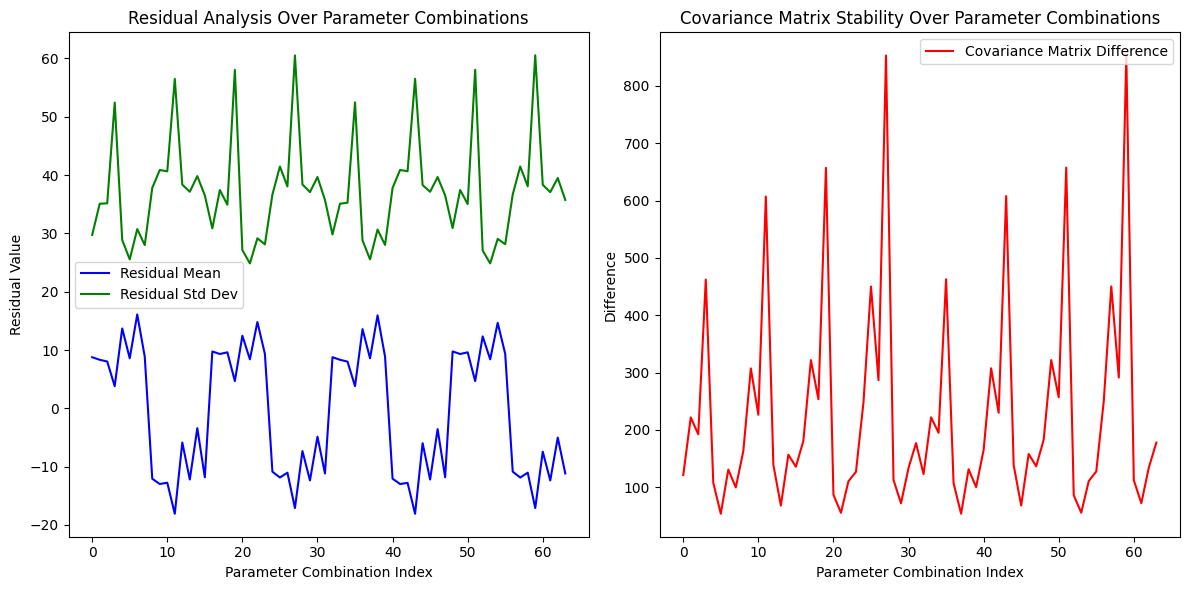

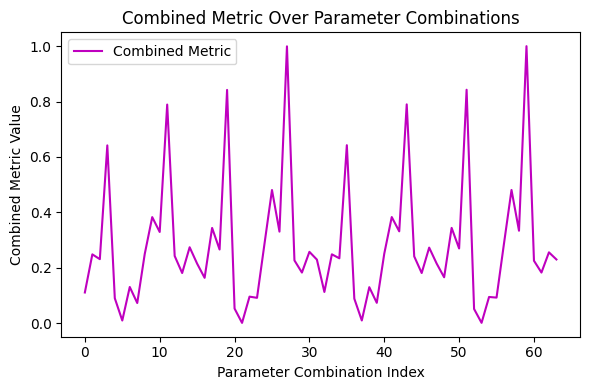

Best parameters saved to ../Outputs/80%train_5iter_commetrics_patient_level_full_AM/best_parameters.json
All results saved to ../Outputs/80%train_5iter_commetrics_patient_level_full_AM/all_results.csv
Plots saved to ../Outputs/80%train_5iter_commetrics_patient_level_full_AM/residual_covariance_plots.png and ../Outputs/80%train_5iter_commetrics_patient_level_full_AM/combined_metric_plot.png


In [33]:
# Ensure the directory exists
os.makedirs(path, exist_ok=True)

# Assuming `best_params`, `results`, `residual_means`, `residual_stds`, `covariance_diffs`, and `combined_metrics` are already calculated

# Define file paths
results_csv_file = os.path.join(path, "all_results.csv")
residual_plot_file = os.path.join(path, "residual_covariance_plots.png")
combined_metric_plot_file = os.path.join(path, "combined_metric_plot.png")

# # Save best parameters to a CSV file
# best_params_file = os.path.join(path, "best_parameters.csv")
# best_params_df = pd.DataFrame([best_params])
# best_params_df.to_csv(best_params_file, index=False)

# Convert numpy arrays to lists
best_params_serializable = {k: v.tolist() for k, v in best_params.items()}
best_params_file = os.path.join(path, "best_parameters.json")

# Save the best parameters to a JSON file
with open(best_params_file, 'w') as json_file:
    json.dump(best_params_serializable, json_file, indent=4)

print(f"Best parameters saved to {best_params_file}")


# Save all results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(results_csv_file, index=False)

# Visualize and save the metrics

# Plot Residual Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(avg_residual_means, 'b-', label='Residual Mean')
plt.plot(avg_residual_stds, 'g-', label='Residual Std Dev')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Residual Value')
plt.title('Residual Analysis Over Parameter Combinations')
plt.legend()

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, 'r-', label='Covariance Matrix Difference')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Difference')
plt.title('Covariance Matrix Stability Over Parameter Combinations')
plt.legend()

# Save the residual and covariance plots
plt.tight_layout()
plt.savefig(residual_plot_file)

plt.show()

# Plot Combined Metric
plt.figure(figsize=(6, 4))
plt.plot(combined_metrics, 'm-', label='Combined Metric')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Combined Metric Value')
plt.title('Combined Metric Over Parameter Combinations')
plt.legend()

# Save the combined metric plot
plt.tight_layout()
plt.savefig(combined_metric_plot_file)

plt.show()

print(f"Best parameters saved to {best_params_file}")
print(f"All results saved to {results_csv_file}")
print(f"Plots saved to {residual_plot_file} and {combined_metric_plot_file}")

# Retraining

In [97]:
import numpy as np
import os
import json
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [98]:
# Create an output directory if it doesn't exist
output_dir = "../Outputs"

# Change accordingly
experiments_log = "80%train_5iter_commetrics_patient_level_full"
path = os.path.join(output_dir, experiments_log)

In [99]:
best_params_file = os.path.join(path, "best_parameters.json")
# Function to read JSON file
def read_json_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except json.JSONDecodeError:
        print("Error: The file could not be decoded. Ensure it's a valid JSON file.")

best_params = read_json_file(best_params_file)

In [100]:
initial_mean = np.array(best_params["initial_state_mean"])
A = np.array(best_params["transition_matrix"])
C = np.array(best_params["observation_matrix"])
Q = np.array(best_params["process_noise_covariance"])
R = np.array(best_params["observation_noise_covariance"])
P_0 = np.array(best_params["initial_covariance"])

In [101]:
# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Filter out patients with fewer than 3 records
patient_record_counts = data_cleaned['usubjid'].value_counts()
patients_to_keep = patient_record_counts[patient_record_counts >= 3].index
data_cleaned = data_cleaned[data_cleaned['usubjid'].isin(patients_to_keep)]

# Preprocess the data 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Split the data into train and test sets by patients
patients = data_cleaned['usubjid'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

train_data = data_cleaned[data_cleaned['usubjid'].isin(train_patients)]
test_data = data_cleaned[data_cleaned['usubjid'].isin(test_patients)]

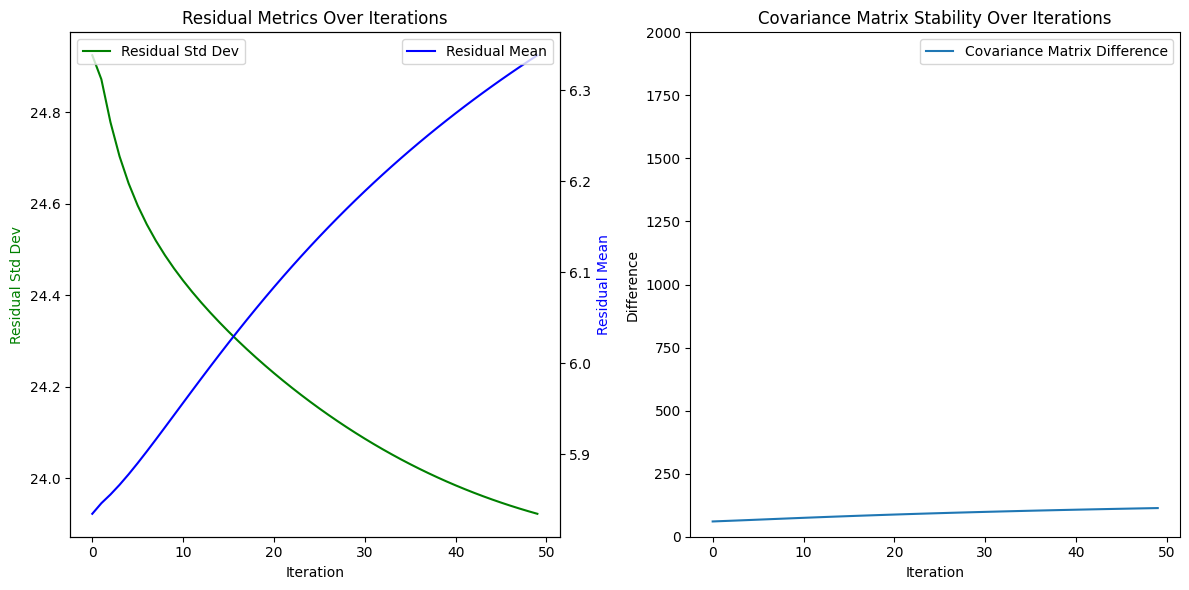

In [102]:
kf = KalmanFilter(
initial_state_mean=initial_mean,
transition_matrices=A,
observation_matrices=C,
transition_covariance=Q,
observation_covariance=R,
initial_state_covariance=P_0,
n_dim_obs=len(features),
n_dim_state=len(features)
)
# Estimate the Kalman Filter parameters using EM algorithm and track convergence metrics
residual_means = []
residual_stds = []
covariance_diffs = []
prev_covariance_matrix = None
avg_residual_means = []
avg_residual_stds = []
for i in range(50):
    for usubjid, group in train_data.groupby('usubjid'):
        # Shuffle and sort by 'ady_dna'
        # group = group.sample(frac=1, random_state=42).sort_values('ady_dna')
        
        # Extract features and target
        X_train = group[features].values
        y_train = group[target].values
        
        try:
            # Train the filter using EM
            kf = kf.em(X_train, n_iter=1)
        except Exception as e:
            print(f"An error occurred while training for patient {usubjid}: {e}")
            continue  # Skip this patient and proceed to the next one
    

    # Test on the test data, patient by patient
    total_residual_mean = 0
    total_residual_std = 0
    total_covariance_diff = 0
    patient_count = 0
    
    for usubjid, group in test_data.groupby('usubjid'):
        X_test = group[features].values
        y_test = group[target].values

        # Filter the test data
        state_means, state_covariances = kf.filter(X_test)
        
        # Metric 1: Residual Analysis
        residuals = X_test - state_means
        residual_mean = np.mean(residuals)
        residual_std = np.std(residuals)
        
        # Metric 2: Covariance Matrix Stability
        avg_covariance_matrix = np.mean(state_covariances, axis=0)
        
        if patient_count > 0:
            covariance_diff = np.linalg.norm(avg_covariance_matrix - prev_avg_covariance_matrix)
        else:
            covariance_diff = 0  # No comparison for the first iteration
        
        prev_avg_covariance_matrix = avg_covariance_matrix
        
        # Accumulate results for overall metrics
        total_residual_mean += residual_mean
        total_residual_std += residual_std
        total_covariance_diff += covariance_diff
        patient_count += 1
    
    # Calculate the average metrics over all patients
    avg_residual_mean = total_residual_mean / patient_count
    avg_residual_std = total_residual_std / patient_count
    avg_covariance_diff = total_covariance_diff / patient_count
    
    covariance_diffs.append(avg_covariance_diff)
    avg_residual_means.append(avg_residual_mean)
    avg_residual_stds.append(avg_residual_std)

# Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Residual Std Dev with Residual Mean on a secondary Y-axis
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(avg_residual_stds, 'g-', label='Residual Std Dev')
ax2.plot(avg_residual_means, 'b-', label='Residual Mean')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual Std Dev', color='g')
ax2.set_ylabel('Residual Mean', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Residual Metrics Over Iterations')

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, label='Covariance Matrix Difference')
plt.ylim(0, 2000)
plt.title('Covariance Matrix Stability Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

In [103]:
optimization = {
    'initial_state_mean': kf.initial_state_mean,
    'transition_matrix': kf.transition_matrices,
    'observation_matrix': kf.observation_matrices,
    'process_noise_covariance': kf.transition_covariance,
    'observation_noise_covariance': kf.observation_covariance,
    'initial_covariance': kf.initial_state_covariance,
}

In [104]:
# Create a DataFrame to store the parameter ranges and the best parameters
parameter_data = {
    'Parameter': [],
    'Range': [],
    'Selected': [],
    "optimization": []
}

for param_name, param_values in parameter_ranges.items():
    parameter_data['Parameter'].append(param_name)
    parameter_data['Range'].append(param_values)
    parameter_data['Selected'].append(best_params[param_name])
    parameter_data["optimization"].append(optimization[param_name])

parameter_df = pd.DataFrame(parameter_data)

# Display the DataFrame
parameter_df

,Parameter,Range,Selected,optimization
0,initial_state_mean,"[[0.0, 0.0], [1.0, 1.0]]","[0.0, 0.0, 0.0]","[28.088691812980837, 0.1808541608127207, 95.87..."
1,transition_matrix,"[[[1.0, 0.0], [0.0, 1.0]], [[0.95, 0.0], [0.0,...","[[0.95, 0.0, 0.0], [0.0, 0.95, 0.0], [0.0, 0.0...","[[0.95, 0.0, 0.0], [0.0, 0.95, 0.0], [0.0, 0.0..."
2,observation_matrix,"[[[1.0, 0.0], [0.0, 1.0]], [[0.9, 0.0], [0.0, ...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
3,process_noise_covariance,"[[[0.01, 0.0], [0.0, 0.01]], [[0.1, 0.0], [0.0...","[[0.1, 0.0, 0.0], [0.0, 0.1, 0.0], [0.0, 0.0, ...","[[37.49564075923643, 0.28362536961365087, 382...."
4,observation_noise_covariance,"[[[0.1, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, ...","[[0.1, 0.0, 0.0], [0.0, 0.1, 0.0], [0.0, 0.0, ...","[[42.4061272077496, 0.28236617018139687, 79.94..."
5,initial_covariance,"[[[0.1, 0.0], [0.0, 0.1]], [[1.0, 0.0], [0.0, ...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...","[[0.0006393912957491921, 1.385530958408765e-06..."


In [105]:
parameter_profile = os.path.join(path, "parameters.csv")
parameter_df.to_csv(parameter_profile)

# Test

In [106]:
X_test = test_data[features].values
y_test = test_data["label"].values

In [107]:
state_means, state_covariances = kf.filter(X_test)

In [108]:
# Use the state means for predictions
predicted_allosure = state_means[:, 1]
predicted_allomap = state_means[:, 0]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)
allosure_labels = (X_test[:, 1] > 0.5).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate predicted allosure AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"predicted_AUC: {auc}")

# Calculate true allosure AUC
auc = roc_auc_score(y_test, X_test[:, 1])
print(f"baseline_AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"kf Accuracy: {accuracy}")

accuracy = accuracy_score(y_test, allosure_labels)
print(f"baseline Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       357
         1.0       0.44      0.37      0.40       147

    accuracy                           0.68       504
   macro avg       0.60      0.59      0.59       504
weighted avg       0.66      0.68      0.67       504

Confusion Matrix:
[[289  68]
 [ 93  54]]
predicted_AUC: 0.6272032622572838
baseline_AUC: 0.6639798776653518
kf Accuracy: 0.6805555555555556
baseline Accuracy: 0.6984126984126984
